In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import numpy as np

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [49]:
X=np.load('X_val.npy')
y=np.load('y_val.npy')

In [50]:
from keras import layers, models
from keras.models import load_model
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def model_load(model):
    model = load_model(model,compile=False)
    model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4), 
            metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])
    
    return model

In [51]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [52]:
#ensemble할 model load

model1=model_load('./G_팔로미_models/VGG16_fine_tuning_3(706).hdf5')
model2=model_load('./G_팔로미_models/VGG16_fine_tuning_2(623)_no callback.hdf5')
model3=model_load('./G_팔로미_models/Inception v3_fine tuning_2(613).hdf5')

members = [model1, model2, model3]

In [53]:
# stacked generalization with neural net meta model on blobs dataset
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax

In [54]:
# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unuque layer name' issue
            layer.name = 'ensemble_' + str(i+1) + '_' + layer.name

    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    # concatenate merge output from each model
    ensemble_outputs = [model.input for model in members]
    
    merge = concatenate(ensemble_outputs)
    flatten=layers.Flatten()(merge)
    hidden = Dense(9, activation = 'relu')(flatten)
    output = Dense(4, activation = 'softmax')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)

    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [45]:
# define ensemble model
stacked_model = define_stacked_model(members)

In [47]:
stacked_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ensemble_1_ensemble_1_ensemble_ (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
ensemble_2_ensemble_2_ensemble_ (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
ensemble_3_ensemble_3_ensemble_ (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 224, 224, 9)  0           ensemble_1_ensemble_1_ensemble_1_
                                                                 ensemble_2_ensemble_2_ensem

In [48]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='model_stacking.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)

In [42]:
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # encode output data
    # fir model
    model.fit(X, inputy, epochs=300, callbacks=[checkpoint])

In [43]:
# fit stacked model on test dataset
fit_stacked_model(stacked_model, X, y)

ValueError: Error when checking target: expected dense_10 to have 4 dimensions, but got array with shape (1712, 4)

In [19]:
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # make prediction
    return model.predict(X)

In [20]:
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, X)

y_label=np.argmax(y,axis=1)
predict=np.argmax(yhat,axis=1)


acc = accuracy_score(y_label, predict)
print('Stacked Test Accracy : %.3f' % acc)

Stacked Test Accracy : 0.726


In [42]:
#AUC 출력하기
from sklearn.metrics import roc_curve, roc_auc_score, auc

roc_auc_score(y_test, yhat)

0.9869985138173012

In [43]:
from sklearn.metrics import confusion_matrix

matrix =confusion_matrix(y_label, predict)

matrix

array([[242,   0,   0,   0],
       [ 23, 115,   0,   0],
       [  7,   0, 161,   0],
       [  6,   0,   0, 162]], dtype=int64)

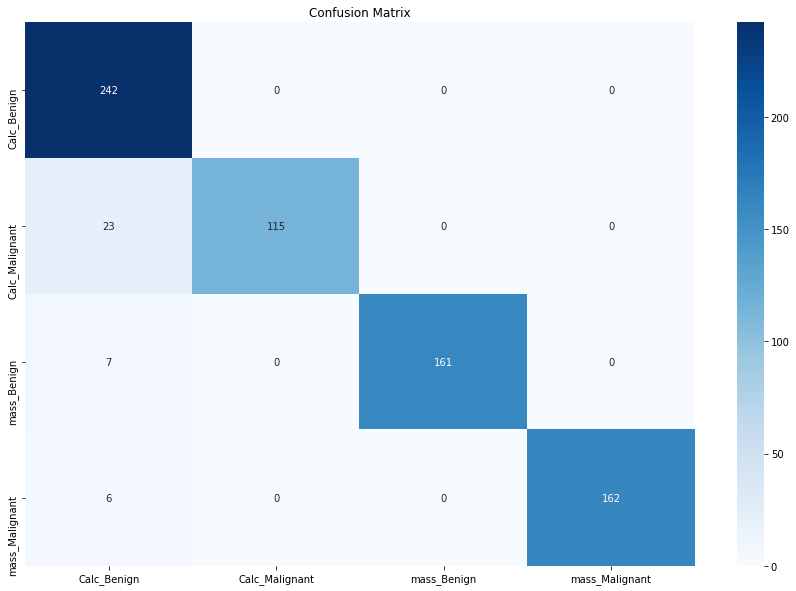

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


index = ['Calc_Benign','Calc_Malignant','mass_Benign','mass_Malignant']  
columns = ['Calc_Benign','Calc_Malignant','mass_Benign','mass_Malignant']  
cm_df = pd.DataFrame(matrix,columns,index)                      
plt.figure(figsize=(15,10)) 
plt.title("Confusion Matrix")
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')